In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [2]:
data = pd.read_csv("data/creditcard.csv", index_col=0)

# Ignore 'Time' and 'Amount' columns, keep only the encoded values (V1 to V28) and 'Class' (labels)
X = data.drop(columns=['Class', 'Amount'])
y = data['Class']

In [3]:
# Source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [4]:
# Split the data into 80% train and 20% test, stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

# Further split train set into 30% labeled and 70% unlabeled
X_train_lab, X_train_unlab, y_train_lab, y_train_unlab = train_test_split(X_train, y_train, test_size=0.7, stratify=y_train, random_state=42)

In [5]:
# Standardize features (important for SVM and other classifiers)
scaler = StandardScaler()
X_train_lab = scaler.fit_transform(X_train_lab)
X_train_unlab = scaler.transform(X_train_unlab)
X_test = scaler.transform(X_test)

print(f'Train set (labeled): {X_train_lab.shape}, Train set (unlabeled): {X_train_unlab.shape}, Test set: {X_test.shape}')

Train set (labeled): (136471, 28), Train set (unlabeled): (318433, 28), Test set: (113726, 28)


In [6]:
svm = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(svm, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_lab, y_train_lab)

print(f'Best parameters: {grid_search.best_params_}')
best_svm = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [17]:
#Best parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_svm = SVC(C=10, degree=2, gamma='scale', kernel='rbf')

num_repeats = 10
accuracies_base = []
f1scores_base = []
iterations = []

for i in range(num_repeats):

    best_svm.fit(X_train_lab, y_train_lab)
    y_pred_test = best_svm.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    f1scores_base.append(f1)
    accuracies_base.append(accuracy)
    
    iterations.append(i + 1)

    print(f'Run {i+1}: Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

Run 1: Accuracy = 0.9954, F1 Score: 0.9954
Run 2: Accuracy = 0.9954, F1 Score: 0.9954
Run 3: Accuracy = 0.9954, F1 Score: 0.9954
Run 4: Accuracy = 0.9954, F1 Score: 0.9954
Run 5: Accuracy = 0.9954, F1 Score: 0.9954
Run 6: Accuracy = 0.9954, F1 Score: 0.9954
Run 7: Accuracy = 0.9954, F1 Score: 0.9954
Run 8: Accuracy = 0.9954, F1 Score: 0.9954
Run 9: Accuracy = 0.9954, F1 Score: 0.9954
Run 10: Accuracy = 0.9954, F1 Score: 0.9954


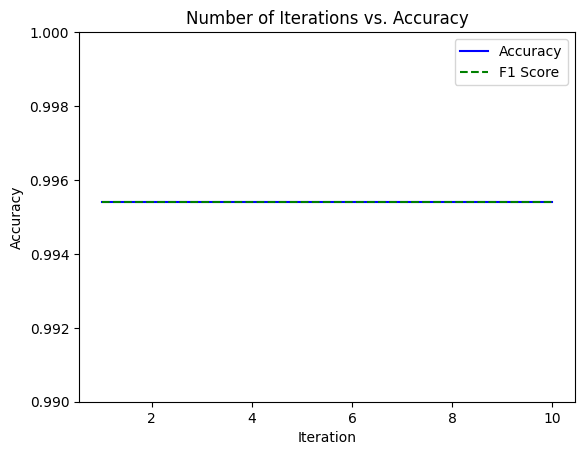

In [32]:
plt.plot(iterations, accuracies_base, marker='', linestyle='-', label='Accuracy', color='blue')
plt.plot(iterations, f1scores_base, marker='', linestyle='--', label='F1 Score', color='green')
plt.ylim([0.99, 1.0])

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Number of Iterations vs. Accuracy')
plt.legend()
plt.show()

In [19]:
y_train_unlab[:] = -1

X_train_combined = np.vstack((X_train_lab, X_train_unlab))
y_train_combined = np.hstack((y_train_lab, y_train_unlab))

label_prop_model = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
label_prop_model.fit(X_train_combined, y_train_combined)

num_repeats = 10
accuracies_label_prop = []
f1scores_label_prop = []

for i in range(num_repeats):
    y_pred_test = label_prop_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    f1scores_label_prop.append(f1)
    accuracies_label_prop.append(accuracy)
    
    print(f'Run {i+1}: Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 1: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 2: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 3: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 4: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 5: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 6: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 7: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 8: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Run 9: Accuracy = 0.9972, F1 Score: 0.9972
Run 10: Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


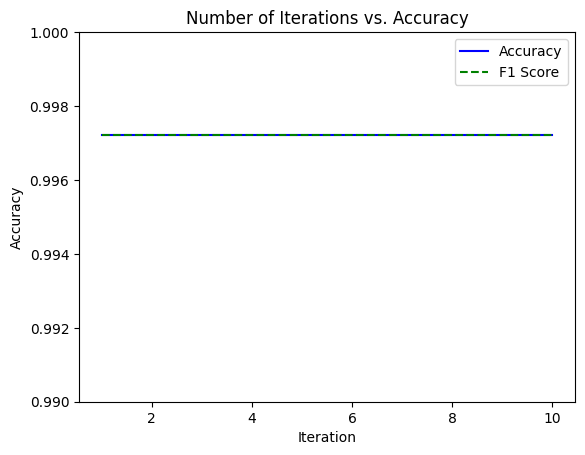

In [33]:
plt.plot(iterations, accuracies_label_prop, marker='', linestyle='-', label='Accuracy', color='blue')
plt.plot(iterations, f1scores_label_prop, marker='', linestyle='--', label='F1 Score', color='green')
plt.ylim([0.99, 1.0])

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Number of Iterations vs. Accuracy')
plt.legend()
plt.show()

In [21]:
print(f'Number of zero rows in X_train_combined: {np.sum(np.all(X_train_combined == 0, axis=1))}')

Number of zero rows in X_train_combined: 0


In [22]:
X_train_complete = np.vstack((X_train_lab, X_train_unlab))
y_train_complete = label_prop_model.transduction_

num_repeats = 10
accuracies_final = []
f1scores_final = []

for i in range(num_repeats):
    best_svm.fit(X_train_complete, y_train_complete)

    y_pred_test_final = best_svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test_final)
    f1 = f1_score(y_test, y_pred_test_final)

    f1scores_final.append(f1)
    accuracies_final.append(accuracy)
    
    print(f'Run {i+1}: Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

Run 1: Accuracy = 0.9975, F1 Score: 0.9975
Run 2: Accuracy = 0.9975, F1 Score: 0.9975
Run 3: Accuracy = 0.9975, F1 Score: 0.9975
Run 4: Accuracy = 0.9975, F1 Score: 0.9975
Run 5: Accuracy = 0.9975, F1 Score: 0.9975
Run 6: Accuracy = 0.9975, F1 Score: 0.9975
Run 7: Accuracy = 0.9975, F1 Score: 0.9975
Run 8: Accuracy = 0.9975, F1 Score: 0.9975
Run 9: Accuracy = 0.9975, F1 Score: 0.9975
Run 10: Accuracy = 0.9975, F1 Score: 0.9975


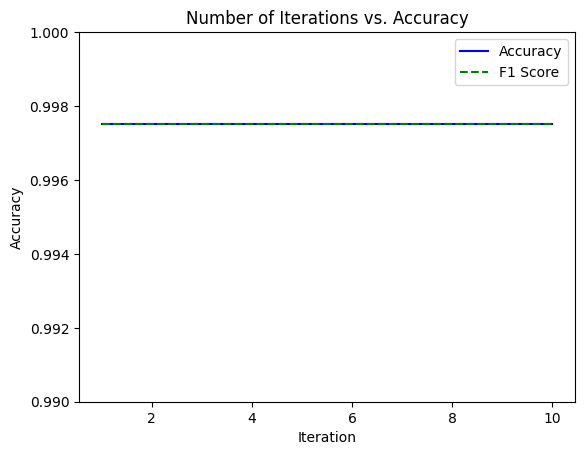

In [34]:
plt.plot(iterations, accuracies_final, marker='', linestyle='-', label='Accuracy', color='blue')
plt.plot(iterations, f1scores_final, marker='', linestyle='--', label='F1 Score', color='green')
plt.ylim([0.99, 1.0])

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Number of Iterations vs. Accuracy')
plt.legend()
plt.show()

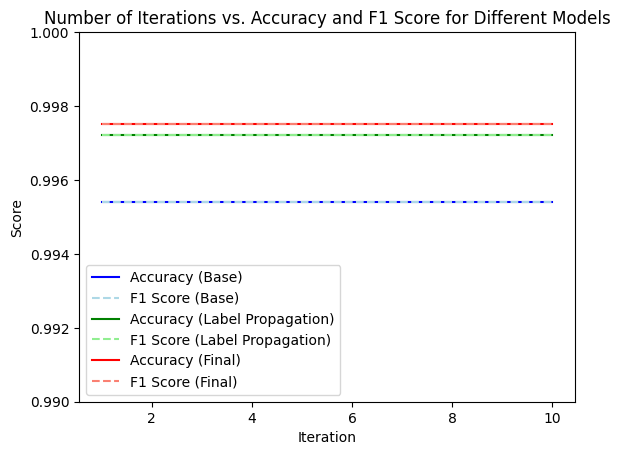

In [38]:
plt.plot(iterations, accuracies_base, marker='', linestyle='-', label='Accuracy (Base)', color='blue')
plt.plot(iterations, f1scores_base, marker='', linestyle='--', label='F1 Score (Base)', color='lightblue')

plt.plot(iterations, accuracies_label_prop, marker='', linestyle='-', label='Accuracy (Label Propagation)', color='green')
plt.plot(iterations, f1scores_label_prop, marker='', linestyle='--', label='F1 Score (Label Propagation)', color='lightgreen')

plt.plot(iterations, accuracies_final, marker='', linestyle='-', label='Accuracy (Final)', color='red')
plt.plot(iterations, f1scores_final, marker='', linestyle='--', label='F1 Score (Final)', color='salmon')

plt.ylim([0.99, 1])

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title('Number of Iterations vs. Accuracy and F1 Score for Different Models')

plt.legend()
plt.show()

In [7]:
best_svm = SVC(C=10, degree=2, gamma='scale', kernel='rbf')
best_svm.fit(X_train_lab, y_train_lab)
y_pred_base = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_base)
f1 = f1_score(y_test, y_pred_base)
print(f'Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

Accuracy = 0.9954, F1 Score: 0.9954


In [8]:
y_train_unlab[:] = -1
X_train_combined = np.vstack((X_train_lab, X_train_unlab))
y_train_combined = np.hstack((y_train_lab, y_train_unlab))

label_prop_model = LabelPropagation(kernel='knn', n_neighbors=7, max_iter=1000)
label_prop_model.fit(X_train_combined, y_train_combined)
y_pred_label_prop = label_prop_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_label_prop)
f1 = f1_score(y_test, y_pred_label_prop)
print(f'Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

Accuracy = 0.9972, F1 Score: 0.9972


c:\Users\hwest\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [9]:
X_train_complete = np.vstack((X_train_lab, X_train_unlab))
y_train_complete = label_prop_model.transduction_

best_svm.fit(X_train_complete, y_train_complete)
y_pred_test_final = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_test_final)
f1 = f1_score(y_test, y_pred_test_final)
print(f'Accuracy = {accuracy:.4f}, F1 Score: {f1:.4f}')

Accuracy = 0.9975, F1 Score: 0.9975


<Figure size 640x480 with 0 Axes>

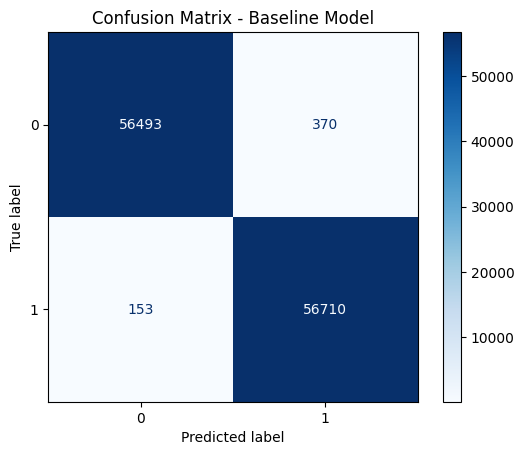

<Figure size 640x480 with 0 Axes>

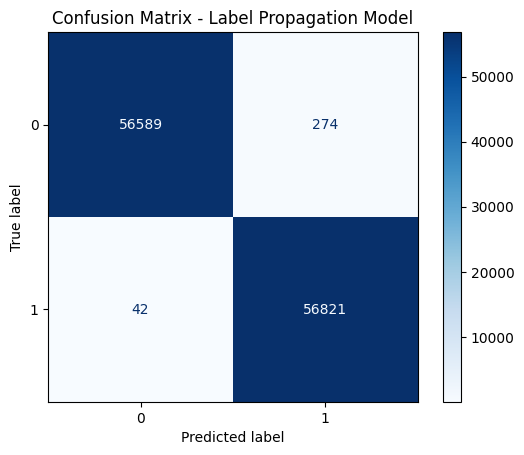

<Figure size 640x480 with 0 Axes>

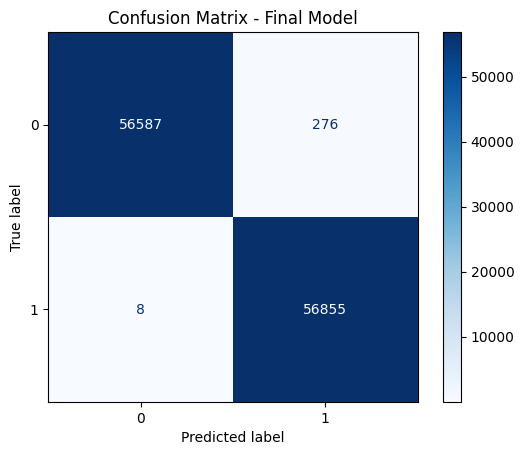

In [11]:
models = {
    "Baseline Model": y_pred_base,
    "Label Propagation Model": y_pred_label_prop,
    "Final Model": y_pred_test_final
}

# Plot confusion matrices
for model_name, y_pred in models.items():
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    plt.figure()
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()